In [ ]:
!pip install transformers torch scikit-learn --quiet

import re
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# # Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.8 MB/s eta 0:00:00
Using device: cuda


In [ ]:
!pip install textblob --quiet
import re

from textblob import TextBlob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Adjust the file path if necessary
train_path = "/content/drive/MyDrive/train.csv"
valid_path = "/content/drive/MyDrive/valid.csv"
train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)
print("Train shape:", train_df.shape)
print(train_df.head())

# Encode the target label column (e.g., "HQ", "LQ_EDIT", "LQ_CLOSE")
label_encoder = LabelEncoder()
train_df["Y"] = label_encoder.fit_transform(train_df["Y"])
print("Unique labels:", train_df["Y"].unique())
print("Encoded labels:", np.unique(train_df["Y"]))

for index, class_ in enumerate(label_encoder.classes_):
    print(f"Integer {index} corresponds to label '{class_}'")


Train shape: (45000, 6)
         Id                                              Title  \
0  34552656             Java: Repeat Task Every Random Seconds   
1  34553034                  Why are Java Optionals immutable?   
2  34553174  Text Overlay Image with Darkened Opacity React...   
3  34553318         Why ternary operator in swift is so picky?   
4  34553755                 hide/show fab with scale animation   

                                                Body  \
0  <p>I'm already familiar with repeating tasks e...   
1  <p>I'd like to understand why Java 8 Optionals...   
2  <p>I am attempting to overlay a title over an ...   
3  <p>The question is very simple, but I just cou...   
4  <p>I'm using custom floatingactionmenu. I need...   

                                                Tags         CreationDate  \
0                                     <java><repeat>  2016-01-01 00:21:59   
1                                   <java><optional>  2016-01-01 02:03:20   
2  <javascr

In [ ]:
def basic_preprocessing(text):
    """
    Basic text preprocessing:
    - Lowercases the text.
    - Removes non-alphanumeric characters.
    - Strips extra spaces.
    """
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Combine "title" and "body" (fill missing values) and preprocess
train_df["processed_text"] = (
    train_df["Title"].fillna("") + " " + train_df["Body"].fillna("")
).apply(basic_preprocessing)
valid_df["processed_text"] = (
    train_df["Title"].fillna("") + " " + train_df["Body"].fillna("")
).apply(basic_preprocessing)

train_df[["Title", "Body", "processed_text"]].head()


,Title,Body,processed_text
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,java repeat task every random seconds pim alre...
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,why are java optionals immutable pid like to u...
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,text overlay image with darkened opacity react...
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",why ternary operator in swift is so picky pthe...
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,hideshow fab with scale animation pim using cu...


In [ ]:
class BertEmbeddingGenerator:
    def __init__(self, model_name="bert-base-uncased", max_length=128):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.model.to(device)
        self.model.eval()
        self.max_length = max_length

    def get_embedding(self, text):
        """
        Returns the [CLS] embedding for a given text using BERT.
        """
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_tensors="pt"
        )

        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            # Use the [CLS] token representation as the sentence embedding
            cls_embedding = outputs.last_hidden_state[:, 0, :]
        return cls_embedding.squeeze().cpu().numpy()

# Instantiate the embedding generator
embedder = BertEmbeddingGenerator(model_name="bert-base-uncased", max_length=128)

# Test the embedding generator on a sample text
sample_text = train_df["processed_text"].iloc[0]
sample_embedding = embedder.get_embedding(sample_text)
print("Sample embedding shape:", sample_embedding.shape)
# print(sample_embedding)
# embeddings = []

# for text in train_df["processed_text"]:
#     embedding = embedder.get_embedding(text)
#     embeddings.append(embedding)
# embedding_matrix = np.vstack(embeddings)
# print("Embedding matrix shape:", embedding_matrix.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Sample embedding shape: (768,)


In [ ]:
from transformers import TFBertModel
import tensorflow as tf

def subjectiveIndicator(model_path=None, max_seq_len=128):
    """
    Loads or builds a BERT-based Keras model that outputs 20 subjective features.
    If model_path is provided, loads weights from that local file.
    Otherwise, uses a fresh TFBertModel from HuggingFace.
    """
    if model_path is not None:
        base_model = TFBertModel.from_pretrained("bert-base-uncased", from_pt=False)
        base_model.load_weights(model_path)
    else:
        base_model = TFBertModel.from_pretrained("bert-base-uncased")

    input_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="attention_mask")

    outputs = base_model(input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output

    hidden = tf.keras.layers.Dense(256, activation="relu")(pooled_output)
    drop = tf.keras.layers.Dropout(0.2)(hidden)

    subj_out = tf.keras.layers.Dense(20, activation="sigmoid")(drop)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=subj_out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [ ]:
import tensorflow as tf
from transformers import TFBertModel

def simulate_subjective_indicators(texts, max_len=128, batch_size=32):
    """
    Returns a (num_samples, 20) array of pseudo-subjective indicators
    using frozen BERT and a randomly initialized dense layer.
    Processes in batches to avoid OOM.
    """
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert = TFBertModel.from_pretrained("bert-base-uncased")
    subjective_head = tf.keras.layers.Dense(20, activation="sigmoid", name="subjective_head")

    encodings = tokenizer(
        texts,
        max_length=max_len,
        truncation=True,
        padding="max_length",
        return_tensors="tf"
    )

    dataset = tf.data.Dataset.from_tensor_slices((
        encodings["input_ids"],
        encodings["attention_mask"]
    )).batch(batch_size)

    all_outputs = []

    for batch_input_ids, batch_attention_mask in dataset:
        outputs = bert(batch_input_ids, attention_mask=batch_attention_mask)
        cls_embeddings = outputs.pooler_output
        subj_output = subjective_head(cls_embeddings)
        all_outputs.append(subj_output.numpy())

    return np.vstack(all_outputs)


In [ ]:
texts = train_df["processed_text"].astype(str).tolist()

subj_feats = simulate_subjective_indicators(texts, batch_size=32)

print(subj_feats.shape)
print(subj_feats[0])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

(45000, 20)
[0.3034901  0.24514775 0.68725795 0.6229294  0.50956047 0.3226088
 0.78662217 0.5037363  0.5648674  0.2269984  0.3323931  0.47952035
 0.7778459  0.610595   0.69815063 0.61895657 0.342345   0.595224
 0.22984292 0.4069996 ]


In [ ]:
subj_df = pd.DataFrame(subj_feats, columns=[f"subj_feat_{i+1}" for i in range(20)])
df_with_subj = pd.concat([train_df.reset_index(drop=True), subj_df], axis=1)
df_with_subj.to_csv("train_with_subjective.csv", index=False)

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_dir = "/content/drive/MyDrive/Ner"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForTokenClassification.from_pretrained(model_dir)
model.to(device)

model.eval()

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
            

In [ ]:
print("Number of labels:", model.config.num_labels)
print("id2label:", model.config.id2label)
print("label2id:", model.config.label2id)

Number of labels: 55
id2label: {0: '-', 1: '--', 2: '----', 3: 'B-Algorithm', 4: 'B-Application', 5: 'B-Class', 6: 'B-Code_Block', 7: 'B-Data_Structure', 8: 'B-Data_Type', 9: 'B-Device', 10: 'B-Error_Name', 11: 'B-File_Name', 12: 'B-File_Type', 13: 'B-Function', 14: 'B-HTML_XML_Tag', 15: 'B-Keyboard_IP', 16: 'B-Language', 17: 'B-Library', 18: 'B-Licence', 19: 'B-Operating_System', 20: 'B-Organization', 21: 'B-Output_Block', 22: 'B-User_Interface_Element', 23: 'B-User_Name', 24: 'B-Value', 25: 'B-Variable', 26: 'B-Version', 27: 'B-Website', 28: 'I-Algorithm', 29: 'I-Application', 30: 'I-Class', 31: 'I-Code_Block', 32: 'I-Data_Structure', 33: 'I-Data_Type', 34: 'I-Device', 35: 'I-Error_Name', 36: 'I-File_Name', 37: 'I-File_Type', 38: 'I-Function', 39: 'I-HTML_XML_Tag', 40: 'I-Keyboard_IP', 41: 'I-Language', 42: 'I-Library', 43: 'I-Licence', 44: 'I-Operating_System', 45: 'I-Output_Block', 46: 'I-User_Interface_Element', 47: 'I-User_Name', 48: 'I-Value', 49: 'I-Variable', 50: 'I-Version', 

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

def ner_inference(texts, tokenizer, model, device, max_length=128, batch_size=32):

    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    input_ids = encodings["input_ids"]
    attention_mask = encodings["attention_mask"]

    dataset = TensorDataset(input_ids, attention_mask)
    loader = DataLoader(dataset, batch_size=batch_size)

    all_results = []

    with torch.no_grad():
        for batch in loader:
            batch_input_ids, batch_attention_mask = [x.to(device) for x in batch]
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            batch_input_ids = batch_input_ids.cpu().numpy()
            preds = preds.cpu().numpy()

            for token_ids, label_ids in zip(batch_input_ids, preds):
                tokens = tokenizer.convert_ids_to_tokens(token_ids)
                token_labels = []
                for token, label_id in zip(tokens, label_ids):
                    if token in ["[CLS]", "[SEP]", "<pad>"]:
                        continue
                    label_str = model.config.id2label.get(label_id, "O")
                    token_labels.append((token, label_str))
                all_results.append(token_labels)

    return all_results


In [ ]:
def ner_features(token_label_pairs):
    """
    Given a list of (token, label) from softner_inference(),
    return a dict counting how many times each label appears.
    """
    counts = {}
    for tok, lab in token_label_pairs:
        if tok in ["[CLS]", "[SEP]", "[PAD]"]:
            continue
        counts[lab] = counts.get(lab, 0) + 1
    return counts


In [ ]:
text = "I used MySQL database with a Python variable foo"
ents = ner_inference([text], tokenizer, model, device)[0]
for token, label in ents:
    print(f"{token:15} --> {label}")
feats = ner_features(ents)
print(feats)
# e.g. {"O": 5, "DATABASE": 1, "VARIABLE": 1, ...}


<s>             --> O
I               --> O
Ġused           --> O
ĠMySQL          --> B-Language
Ġdatabase       --> O
Ġwith           --> O
Ġa              --> O
ĠPython         --> B-Language
Ġvariable       --> O
Ġfoo            --> B-Variable
</s>            --> O
{'O': 8, 'B-Language': 2, 'B-Variable': 1}


In [ ]:
all_features = []
batch_size = 32
texts = train_df["processed_text"].astype(str).tolist()

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    batch_results = ner_inference(batch_texts, tokenizer, model, device, max_length=128)
    for token_label_pairs in batch_results:
        feat_dict = ner_features(token_label_pairs)
        all_features.append(feat_dict)

    print(f"Processed batch {i // batch_size + 1} ({i + len(batch_texts)} / {len(texts)})")

ner_df = pd.DataFrame(all_features).fillna(0)
df_ner = pd.concat([train_df.reset_index(drop=True), ner_df], axis=1)
df_ner.to_csv("train_with_ner.csv", index=False)

Processed batch 1 (32 / 45000)
Processed batch 2 (64 / 45000)
Processed batch 3 (96 / 45000)
Processed batch 4 (128 / 45000)
Processed batch 5 (160 / 45000)
Processed batch 6 (192 / 45000)
Processed batch 7 (224 / 45000)
Processed batch 8 (256 / 45000)
Processed batch 9 (288 / 45000)
Processed batch 10 (320 / 45000)
Processed batch 11 (352 / 45000)
Processed batch 12 (384 / 45000)
Processed batch 13 (416 / 45000)
Processed batch 14 (448 / 45000)
Processed batch 15 (480 / 45000)
Processed batch 16 (512 / 45000)
Processed batch 17 (544 / 45000)
Processed batch 18 (576 / 45000)
Processed batch 19 (608 / 45000)
Processed batch 20 (640 / 45000)
Processed batch 21 (672 / 45000)
Processed batch 22 (704 / 45000)
Processed batch 23 (736 / 45000)
Processed batch 24 (768 / 45000)
Processed batch 25 (800 / 45000)
Processed batch 26 (832 / 45000)
Processed batch 27 (864 / 45000)
Processed batch 28 (896 / 45000)
Processed batch 29 (928 / 45000)
Processed batch 30 (960 / 45000)
Processed batch 31 (99

In [ ]:
ner_df = pd.read_csv("train_with_ner.csv")
subj_df = pd.read_csv("/content/drive/MyDrive/train_with_subjective.csv")

common_cols = set(ner_df.columns) & set(subj_df.columns)
cols_to_drop = [col for col in common_cols if col != 'Id']
subj_df = subj_df.drop(columns=cols_to_drop)

merged_df = pd.concat([ner_df.reset_index(drop=True), subj_df.reset_index(drop=True)], axis=1)


merged_df.to_csv("train_merged.csv", index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train_merged.csv')
df.head()

,Id,Title,Body,Tags,CreationDate,Y,processed_text,O,B-Language,B-Library,...,subj_feat_11,subj_feat_12,subj_feat_13,subj_feat_14,subj_feat_15,subj_feat_16,subj_feat_17,subj_feat_18,subj_feat_19,subj_feat_20
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,1,java repeat task every random seconds pim alre...,56.0,1.0,4.0,...,0.332393,0.479520,0.777846,0.610595,0.698151,0.618957,0.342345,0.595224,0.229843,0.407000
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,0,why are java optionals immutable pid like to u...,22.0,2.0,0.0,...,0.371032,0.452007,0.749921,0.656861,0.714080,0.644150,0.293702,0.611762,0.234797,0.443112
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,0,text overlay image with darkened opacity react...,86.0,0.0,2.0,...,0.397289,0.533651,0.705417,0.677571,0.664553,0.653888,0.233543,0.620301,0.325871,0.492110
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,0,why ternary operator in swift is so picky pthe...,94.0,0.0,1.0,...,0.393385,0.507251,0.755828,0.679308,0.629112,0.588271,0.321993,0.565804,0.237159,0.411909
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,0,hideshow fab with scale animation pim using cu...,73.0,0.0,0.0,...,0.292074,0.467954,0.766447,0.605255,0.745469,0.655420,0.294444,0.604168,0.246374,0.408546


In [ ]:
def extract_lexical_features(title, body):
    """
    Returns a dictionary of lexical & sentiment features from title & body.
    Includes:
      - letter_count, word_count
      - code_block detection & code percentage
      - first/last sentence word count, average sentence word count
      - sentiment (TextBlob polarity, subjectivity)
      - whether the title is interrogative
    """

    features = {}

    # 1. Title letter/word count
    title_letters = len(title)
    title_words = len(title.split())
    features["title_letter_count"] = title_letters
    features["title_word_count"] = title_words

    # 2. Body letter/word count
    body_letters = len(body)
    body_words = len(body.split())
    features["body_letter_count"] = body_letters
    features["body_word_count"] = body_words

    # 3. Simple code block detection & code percentage
    code_blocks = re.findall(r"<code>(.*?)</code>", body, flags=re.DOTALL)
    code_text = "".join(code_blocks)
    code_length = len(code_text)
    total_length = len(body)
    code_pct = (code_length / total_length) if total_length > 0 else 0
    features["code_percentage"] = code_pct
    features["code_block_count"] = len(code_blocks)

    # 4. Sentence-level features for the body
    sentences = [s.strip() for s in body.split('.') if s.strip()]
    if len(sentences) > 0:
        first_sentence = sentences[0]
        last_sentence = sentences[-1]
        features["first_sentence_word_count"] = len(first_sentence.split())
        features["last_sentence_word_count"] = len(last_sentence.split())
        # average words per sentence
        avg_words = np.mean([len(s.split()) for s in sentences])
        features["avg_sentence_word_count"] = avg_words
    else:
        features["first_sentence_word_count"] = 0
        features["last_sentence_word_count"] = 0
        features["avg_sentence_word_count"] = 0

    # 5. Simple sentiment (TextBlob) for title/body
    title_blob = TextBlob(title)
    body_blob = TextBlob(body)
    features["title_sentiment_polarity"] = title_blob.sentiment.polarity
    features["title_sentiment_subjectivity"] = title_blob.sentiment.subjectivity
    features["body_sentiment_polarity"] = body_blob.sentiment.polarity
    features["body_sentiment_subjectivity"] = body_blob.sentiment.subjectivity

    # 6. Interrogative title (check if title ends with '?')
    features["title_is_interrogative"] = int(title.strip().endswith('?'))

    return features


In [ ]:
def extract_softner_features(row, ner_labels):
    """
    row: a single row from the DataFrame (Series or namedtuple).
    ner_labels: list of SoftNER label columns, e.g. ["DATABASE", "VARIABLE", "ALGORITHM", ...]

    We assume each column in ner_labels has a count of how many tokens had that label.
    Return a dict of total_ner_tokens, plus count and percentage for each label.
    """
    feats = {}
    # sum up total tokens recognized (including O or not, up to you)
    total_tokens = 0
    for label in ner_labels:
        if label in row:
            val = row[label]
            total_tokens += val

    feats["total_ner_tokens"] = total_tokens

    # For each label, store count and percentage
    for label in ner_labels:
        if label in row:
            count = row[label]
            feats[f"{label}_count"] = count
            if total_tokens > 0:
                feats[f"{label}_pct"] = count / total_tokens
            else:
                feats[f"{label}_pct"] = 0.0
    return feats

In [ ]:
ner_label_cols = [
    col for col in df.columns
    if col == "O" or col.startswith("B-") or col.startswith("I-")
]

print("Detected NER label columns:", ner_label_cols)

Detected NER label columns: ['O', 'B-Language', 'B-Library', 'I-Library', 'I-Function', 'B-Value', 'I-Value', 'B-Application', 'B-User_Name', 'B-Data_Type', 'B-Variable', 'B-Version', 'I-Variable', 'B-User_Interface_Element', 'B-Device', 'B-Code_Block', 'I-Code_Block', 'B-Function', 'B-Class', 'I-User_Interface_Element', 'I-Application', 'B-Output_Block', 'I-Output_Block', 'B-HTML_XML_Tag', 'I-HTML_XML_Tag', 'B-Operating_System', 'I-Error_Name', 'B-Error_Name', 'I-Operating_System', 'B-Website', 'B-Data_Structure', 'B-File_Name', 'I-File_Name', 'I-Device', 'B-File_Type', 'I-Class', 'I-User_Name', 'I-Algorithm', 'I-Data_Type', 'I-Version', 'I-Language', 'B-Algorithm', 'I-Data_Structure', 'I-Website', 'B-Keyboard_IP', 'I-Keyboard_IP']


In [ ]:
all_stats = []
for idx, row in df.iterrows():
    title = row.get("Title", "")
    body = row.get("Body", "")

    lexical_dict = extract_lexical_features(title, body)
    ner_dict = extract_softner_features(row, ner_label_cols)

    combined = {**lexical_dict, **ner_dict}
    all_stats.append(combined)

stats_df = pd.DataFrame(all_stats)

# Merge the new features with the original DataFrame
df_stats = pd.concat([df.reset_index(drop=True), stats_df], axis=1)
df_stats.to_csv("train_stats.csv", index=False)

In [ ]:
df_stats = pd.read_csv("/content/drive/MyDrive/train_stats.csv")

df_stats.head()

,Id,Title,Body,Tags,CreationDate,Y,processed_text,O,B-Language,B-Library,...,B-Algorithm_count,B-Algorithm_pct,I-Data_Structure_count,I-Data_Structure_pct,I-Website_count,I-Website_pct,B-Keyboard_IP_count,B-Keyboard_IP_pct,I-Keyboard_IP_count,I-Keyboard_IP_pct
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,1,java repeat task every random seconds pim alre...,56.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,0,why are java optionals immutable pid like to u...,22.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,0,text overlay image with darkened opacity react...,86.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,0,why ternary operator in swift is so picky pthe...,94.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,0,hideshow fab with scale animation pim using cu...,73.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Original columns:", df_stats.columns.tolist())
print("Shape:", df_stats.shape)

Original columns: ['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'Y', 'processed_text', 'O', 'B-Language', 'B-Library', 'I-Library', 'I-Function', 'B-Value', 'I-Value', 'B-Application', 'B-User_Name', 'B-Data_Type', 'B-Variable', 'B-Version', 'I-Variable', 'B-User_Interface_Element', 'B-Device', 'B-Code_Block', 'I-Code_Block', 'B-Function', 'B-Class', 'I-User_Interface_Element', 'I-Application', 'B-Output_Block', 'I-Output_Block', 'B-HTML_XML_Tag', 'I-HTML_XML_Tag', 'B-Operating_System', 'I-Error_Name', 'B-Error_Name', 'I-Operating_System', 'B-Website', 'B-Data_Structure', 'B-File_Name', 'I-File_Name', 'I-Device', 'B-File_Type', 'I-Class', 'I-User_Name', 'I-Algorithm', 'I-Data_Type', 'I-Version', 'I-Language', 'B-Algorithm', 'I-Data_Structure', 'I-Website', 'B-Keyboard_IP', 'I-Keyboard_IP', 'Id.1', 'subj_feat_1', 'subj_feat_2', 'subj_feat_3', 'subj_feat_4', 'subj_feat_5', 'subj_feat_6', 'subj_feat_7', 'subj_feat_8', 'subj_feat_9', 'subj_feat_10', 'subj_feat_11', 'subj_feat_12', 'subj_

In [ ]:
# A) Subjective columns (20 features from Component 1)
subjective_col_map = {
    "subj_feat_1": "Clear intent",
    "subj_feat_2": "Conversational",
    "subj_feat_3": "Expects short answer",
    "subj_feat_4": "Fact seeking",
    "subj_feat_5": "Has accepted answer",
    "subj_feat_6": "Interestingness others",
    "subj_feat_7": "Interestingness self",
    "subj_feat_8": "Multi intent",
    "subj_feat_9": "Not a question",
    "subj_feat_10": "Opinion seeking",
    "subj_feat_11": "Type-choice",
    "subj_feat_12": "Type-compare",
    "subj_feat_13": "Type-consequence",
    "subj_feat_14": "Type-definition",
    "subj_feat_15": "Type-entity",
    "subj_feat_16": "Type-instructions",
    "subj_feat_17": "Type-procedure",
    "subj_feat_18": "Type-reason explanation",
    "subj_feat_19": "Type-spelling",
    "subj_feat_20": "Well written"
}

# B) Software-related columns (from SoftNER outputs)


# C) Lexical/statistical columns (from general statistical analysis in Component 3)
lexical_cols = [
    "title_letter_count", "title_word_count",
    "body_letter_count", "body_word_count",
    "code_percentage", "code_block_count",
    "first_sentence_word_count", "last_sentence_word_count",
    "avg_sentence_word_count",
    "title_sentiment_polarity", "title_sentiment_subjectivity",
    "body_sentiment_polarity", "body_sentiment_subjectivity",
    "title_is_interrogative"
]

# D) ID/Label/Other essential columns (adjust as necessary)
id_cols = ["Id", "Title", "Body", "Tags", "CreationDate", "processed_text", "Y"]


In [ ]:
df_stats.rename(columns=subjective_col_map, inplace=True)

subjective_cols = list(subjective_col_map.values())

subjective_in_df = [col for col in subjective_cols if col in df_stats.columns]

lexical_in_df    = [col for col in lexical_cols if col in df_stats.columns]
id_in_df         = [col for col in id_cols if col in df_stats.columns]

id_set         = set(id_cols)
subjective_set = set(subjective_cols)
lexical_set    = set(lexical_cols)

all_cols = set(df_stats.columns)

software_set = all_cols - id_set - subjective_set - lexical_set
software_in_df = list(software_set)


df_subjective = df_stats[id_in_df + subjective_in_df]
df_software   = df_stats[id_in_df + software_in_df]
df_lexical    = df_stats[id_in_df + lexical_in_df]

In [ ]:
df_subjective.to_csv("train_subjective.csv", index=False)
df_software.to_csv("train_software.csv", index=False)
df_lexical.to_csv("train_lexical.csv", index=False)

In [ ]:
df_subjective.columns


Index(['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'processed_text', 'Y',
       'Clear intent', 'Conversational', 'Expects short answer',
       'Fact seeking', 'Has accepted answer', 'Interestingness others',
       'Interestingness self', 'Multi intent', 'Not a question',
       'Opinion seeking', 'Type-choice', 'Type-compare', 'Type-consequence',
       'Type-definition', 'Type-entity', 'Type-instructions', 'Type-procedure',
       'Type-reason explanation', 'Type-spelling', 'Well written'],
      dtype='object')

In [ ]:
print(df_software.columns.tolist())


['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'processed_text', 'Y', 'I-Class', 'I-Library_pct', 'B-Output_Block_count', 'I-Library_count', 'B-File_Type_pct', 'B-Algorithm_count', 'B-Variable_pct', 'I-File_Name_pct', 'B-Version_pct', 'I-Error_Name_pct', 'B-Value_pct', 'B-Data_Type_count', 'I-User_Interface_Element_count', 'I-Version_count', 'B-User_Interface_Element', 'B-Website', 'I-Data_Type_count', 'B-File_Type_count', 'B-Keyboard_IP_count', 'B-Application_count', 'B-Code_Block_count', 'I-Algorithm_pct', 'B-Keyboard_IP_pct', 'I-Output_Block_count', 'B-File_Name', 'B-Application_pct', 'Id.1', 'I-Device_count', 'B-Error_Name_pct', 'I-Algorithm', 'B-Class_pct', 'B-Operating_System_count', 'I-Language', 'B-Device', 'I-Output_Block', 'B-Website_count', 'I-Function_pct', 'B-Function_count', 'I-Data_Structure_count', 'B-HTML_XML_Tag_count', 'I-HTML_XML_Tag_count', 'B-Class', 'I-Code_Block_pct', 'B-Version', 'B-Language', 'I-Operating_System', 'B-Code_Block_pct', 'B-Error_Name_count', 'I-

In [ ]:
df_lexical.columns


Index(['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'processed_text', 'Y',
       'title_letter_count', 'title_word_count', 'body_letter_count',
       'body_word_count', 'code_percentage', 'code_block_count',
       'first_sentence_word_count', 'last_sentence_word_count',
       'avg_sentence_word_count', 'title_sentiment_polarity',
       'title_sentiment_subjectivity', 'body_sentiment_polarity',
       'body_sentiment_subjectivity', 'title_is_interrogative'],
      dtype='object')

In [ ]:
df_stats.columns

Index(['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'Y', 'processed_text',
       'O', 'B-Language', 'B-Library',
       ...
       'B-Algorithm_count', 'B-Algorithm_pct', 'I-Data_Structure_count',
       'I-Data_Structure_pct', 'I-Website_count', 'I-Website_pct',
       'B-Keyboard_IP_count', 'B-Keyboard_IP_pct', 'I-Keyboard_IP_count',
       'I-Keyboard_IP_pct'],
      dtype='object', length=181)

In [ ]:
summary_data = []
df = df_stats
for col in df.columns:
    dtype = df[col].dtype
    unique_vals = df[col].nunique()

    # Initialize stats
    mean_val = ""
    min_val = ""
    max_val = ""

    if np.issubdtype(dtype, np.number):
        mean_val = round(df[col].mean(), 4)
        min_val = round(df[col].min(), 4)
        max_val = round(df[col].max(), 4)

    summary_data.append([col, dtype, unique_vals, mean_val, min_val, max_val])

# Create summary dataframe
summary_df = pd.DataFrame(summary_data, columns=["Column", "Data Type", "Unique Values", "Mean", "Min", "Max"])

# Save to text file
summary_df.to_string(buf=open("column_stats_summary.txt", "w"), index=False)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
exclude_cols = ["Id", "Title", "Body", "Tags", "CreationDate", "processed_text", "Y"]
numeric_cols = df.select_dtypes(include=[np.number]).columns.difference(["Y"]).tolist()

In [ ]:
generated_feats = pd.DataFrame()

for col in numeric_cols:
    col_data = df[col].copy()

    # 1. Log transform safely: log1p ensures log(0) = 0 and avoids inf
    generated_feats[f"{col}_log"] = np.log1p(np.maximum(col_data, 0))

    # 2. Square transform (safe unless numbers are huge)
    generated_feats[f"{col}_sqr"] = np.power(col_data, 2)

    # 3. Sqrt transform safely
    generated_feats[f"{col}_sqrt"] = np.sqrt(np.maximum(col_data, 0))

<ipython-input-22-a60c3348e480>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  generated_feats[f"{col}_sqr"] = np.power(col_data, 2)
<ipython-input-22-a60c3348e480>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  generated_feats[f"{col}_sqrt"] = np.sqrt(np.maximum(col_data, 0))
<ipython-input-22-a60c3348e480>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead

In [ ]:
df_combined = pd.concat([df, generated_feats], axis=1)

In [ ]:
feature_cols = df_combined.select_dtypes(include=[np.number]).columns.difference(["Y"])
scaler = MinMaxScaler()
df_combined[feature_cols] = scaler.fit_transform(df_combined[feature_cols])

In [ ]:
tfidf = TfidfVectorizer(max_features=300)
tfidf_matrix = tfidf.fit_transform(df_combined["processed_text"].fillna(""))
tokens = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=[f"tfidf_{tok}" for tok in tokens]
)


In [ ]:
df_combined = pd.concat([df_combined.reset_index(drop=True), tfidf_df], axis=1)

In [ ]:
correlations = df_combined.corr(numeric_only=True)["Y"].drop("Y")
low_corr_feats = correlations[correlations.abs() < 0.01].index.tolist()

# Drop those features
df_final = df_combined.drop(columns=low_corr_feats)

In [ ]:
df_final.to_csv("train_features_final.csv", index=False)
print(f"✅ Final dataset saved with {df_final.shape[1]} columns.")
print(f"❌ Dropped {len(low_corr_feats)} low-correlation features.")

✅ Final dataset saved with 844 columns.
❌ Dropped 162 low-correlation features.


<ipython-input-67-5c9ed76dc7f9>:12: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


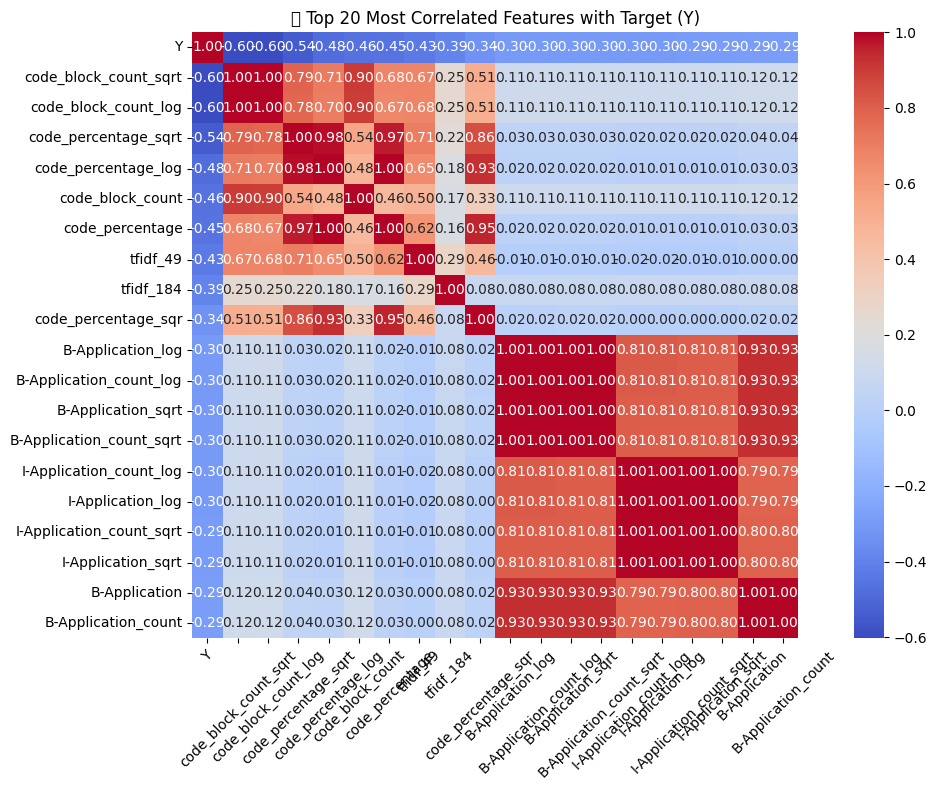

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

top_corr = df_final.corr(numeric_only=True)["Y"].abs().sort_values(ascending=False).head(20).index
corr_matrix = df_final[top_corr].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("🔍 Top 20 Most Correlated Features with Target (Y)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-68-380929300ef3>:12: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


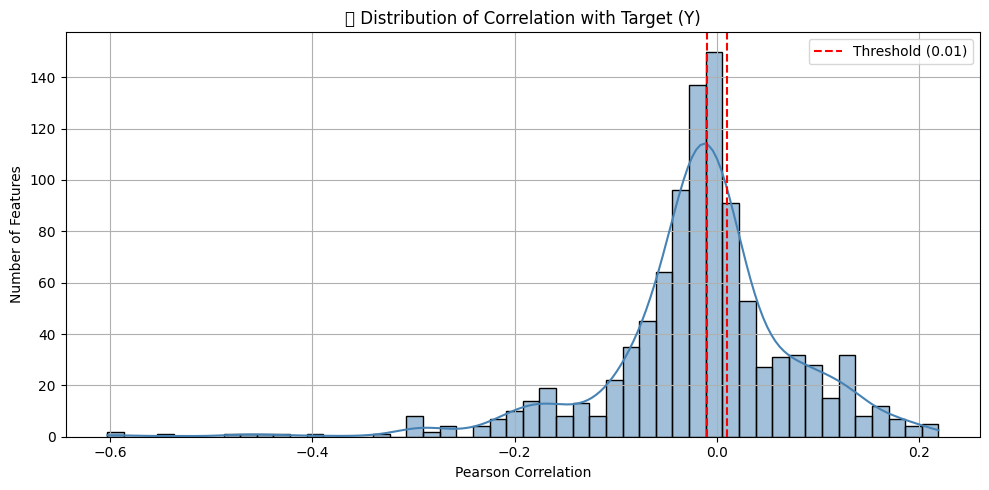

In [ ]:
correlations = df_combined.corr(numeric_only=True)["Y"].drop("Y")

plt.figure(figsize=(10, 5))
sns.histplot(correlations, bins=50, kde=True, color='steelblue')
plt.axvline(0.01, color='red', linestyle='--', label='Threshold (0.01)')
plt.axvline(-0.01, color='red', linestyle='--')
plt.title("📉 Distribution of Correlation with Target (Y)")
plt.xlabel("Pearson Correlation")
plt.ylabel("Number of Features")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

df = pd.read_csv("/content/drive/MyDrive/train_features_final.csv")

In [ ]:
exclude_cols = ["Id", "Title", "Body", "Tags", "CreationDate", "processed_text", "Y"]
X = df.drop(columns=exclude_cols, errors="ignore")
y = df["Y"].astype(int)

In [ ]:
tasks = {
    "task_high_quality":   (y == 0).astype(int),  # 2 => High Quality
    "task_edit":           (y == 2).astype(int),  # 1 => Needs Edit
    "task_close":          (y == 1).astype(int)   # 0 => Should be Closed
}

In [ ]:
xgb_params = {
    "n_estimators": 1000,
    "learning_rate": 0.07,
    "max_depth": 6,
    "colsample_bytree": 1.0,
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "verbosity": 0,  # Silent training
    "tree_method": "gpu_hist"
}

In [ ]:
# # Run the one with Shap for explainability, this for faster processing

# results = {}  # will store Precision, Recall, F1 for each task

# for task_name, binary_labels in tasks.items():
#     # We'll do Stratified 5-fold CV for this binary classification
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#     fold_precisions = []
#     fold_recalls = []
#     fold_f1s = []

#     for train_idx, val_idx in skf.split(X, binary_labels):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = binary_labels.iloc[train_idx], binary_labels.iloc[val_idx]

#         # Instantiate and train XGBoost
#         model = XGBClassifier(**xgb_params)
#         model.fit(X_train, y_train)

#         # Predict on validation set
#         y_pred = model.predict(X_val)

#         # Compute metrics
#         prec = precision_score(y_val, y_pred, zero_division=0)
#         rec = recall_score(y_val, y_pred, zero_division=0)
#         f1 = f1_score(y_val, y_pred, zero_division=0)

#         fold_precisions.append(prec)
#         fold_recalls.append(rec)
#         fold_f1s.append(f1)

#     # Average metrics across the 5 folds
#     results[task_name] = {
#         "Precision": np.mean(fold_precisions),
#         "Recall":    np.mean(fold_recalls),
#         "F1 Score":  np.mean(fold_f1s)
#     }

In [ ]:
import joblib
from google.colab import files


results = {}

for task_name, binary_labels in tasks.items():
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_precisions = []
    fold_recalls    = []
    fold_f1s        = []
    fold_models     = []

    for train_idx, val_idx in skf.split(X, binary_labels):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = binary_labels.iloc[train_idx], binary_labels.iloc[val_idx]

        model = XGBClassifier(**xgb_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        prec = precision_score(y_val, y_pred, zero_division=0)
        rec  = recall_score(y_val, y_pred, zero_division=0)
        f1   = f1_score(y_val, y_pred, zero_division=0)

        fold_precisions.append(prec)
        fold_recalls.append(rec)
        fold_f1s.append(f1)
        fold_models.append(model)

    results[task_name] = {
        "Precision": np.mean(fold_precisions),
        "Recall":    np.mean(fold_recalls),
        "F1 Score":  np.mean(fold_f1s)
    }

    best_idx = int(np.argmax(fold_f1s))

    best_model = fold_models[best_idx]
    best_model.fit(X, binary_labels)

    joblib.dump(best_model, f"best_model_{task_name}.pkl")
    files.download(f"best_model_{task_name}.pkl")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:23:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:25:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:27:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
results_df = pd.DataFrame(results).T.round(4)
print("XGBoost 5-Fold CV Results:")
print(results_df)

XGBoost 5-Fold CV Results:
                   Precision  Recall  F1 Score
task_high_quality     0.8542  0.8333    0.8436
task_edit             0.9484  0.9830    0.9654
task_close            0.8361  0.7584    0.7953


In [ ]:
model_final = XGBClassifier(**xgb_params)
model_final.fit(X, binary_labels)

model_filename = f"{task_name}_xgb_model.json"
model_final.save_model(model_filename)
print(f"✅ Saved final {task_name} model to {model_filename}")


✅ Saved final task_close model to task_close_xgb_model.json


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:46:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [ ]:
!pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=23834a04d2677bc206153ab479aefd902c2db625540b4151b6c2fc25221c13aa
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# Explainability
import shap

results = {}
shap_values_all = {}
X_val_all = {}

for task_name, binary_labels in tasks.items():
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_precisions = []
    fold_recalls    = []
    fold_f1s        = []
    shap_vals_list  = []
    X_val_list      = []

    for train_idx, val_idx in skf.split(X, binary_labels):
        # 1. Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = binary_labels.iloc[train_idx], binary_labels.iloc[val_idx]

        # 2. Train XGBoost
        model = XGBClassifier(**xgb_params)
        model.fit(X_train, y_train)

        # 3. Predict & collect metrics
        y_pred = model.predict(X_val)
        fold_precisions.append(precision_score(y_val, y_pred, zero_division=0))
        fold_recalls.append(recall_score(y_val, y_pred, zero_division=0))
        fold_f1s.append(f1_score(y_val, y_pred, zero_division=0))

        # 4. Explain on hold‑out
        explainer   = shap.TreeExplainer(model, X_train, feature_perturbation="interventional")
        shap_vals   = explainer.shap_values(X_val)         # (n_val, n_features)
        shap_vals_list.append(shap_vals)
        X_val_list.append(X_val)

    # 5. Aggregate metrics
    results[task_name] = {
        "Precision": np.mean(fold_precisions),
        "Recall":    np.mean(fold_recalls),
        "F1 Score":  np.mean(fold_f1s)
    }

    # 6. Aggregate SHAP data
    shap_values_all[task_name] = np.vstack(shap_vals_list)
    X_val_all[task_name]       = pd.concat(X_val_list, axis=0)

100%|===================| 8988/9000 [05:03<00:00]       

In [ ]:
results_df = pd.DataFrame(results).T.round(4)
print("XGBoost 5-Fold CV Results:")
print(results_df)


XGBoost 5-Fold CV Results:
                   Precision  Recall  F1 Score
task_high_quality     0.8542  0.8333    0.8436
task_edit             0.9484  0.9830    0.9654
task_close            0.8361  0.7584    0.7953



SHAP summary for task: task_high_quality


<ipython-input-13-53cdb2002fa9>:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


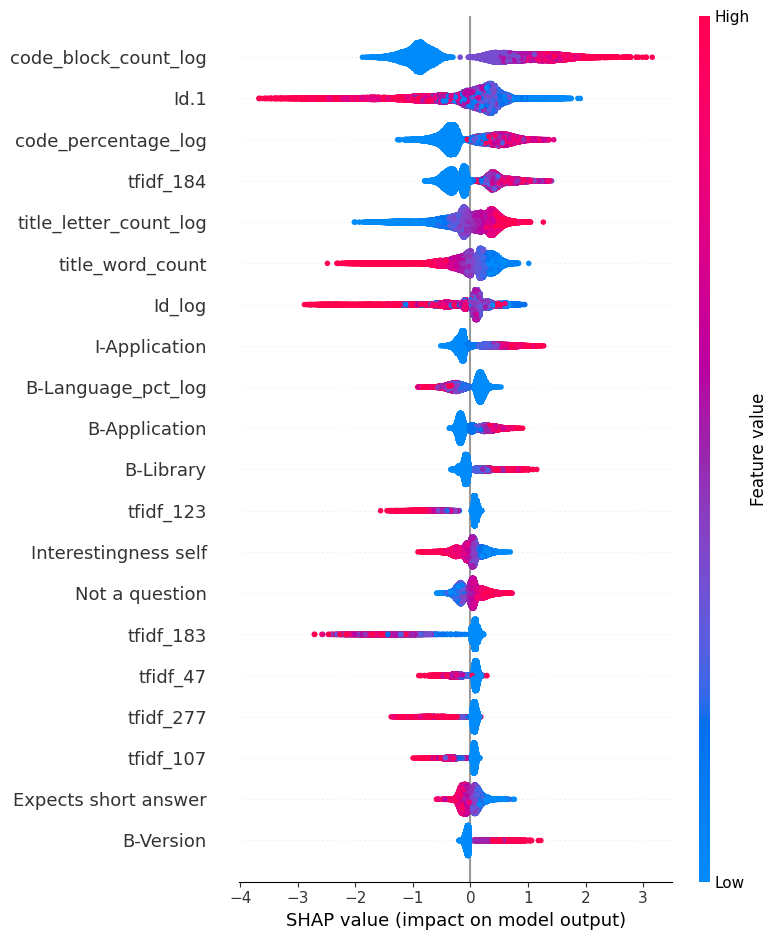


SHAP summary for task: task_edit


<ipython-input-13-53cdb2002fa9>:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


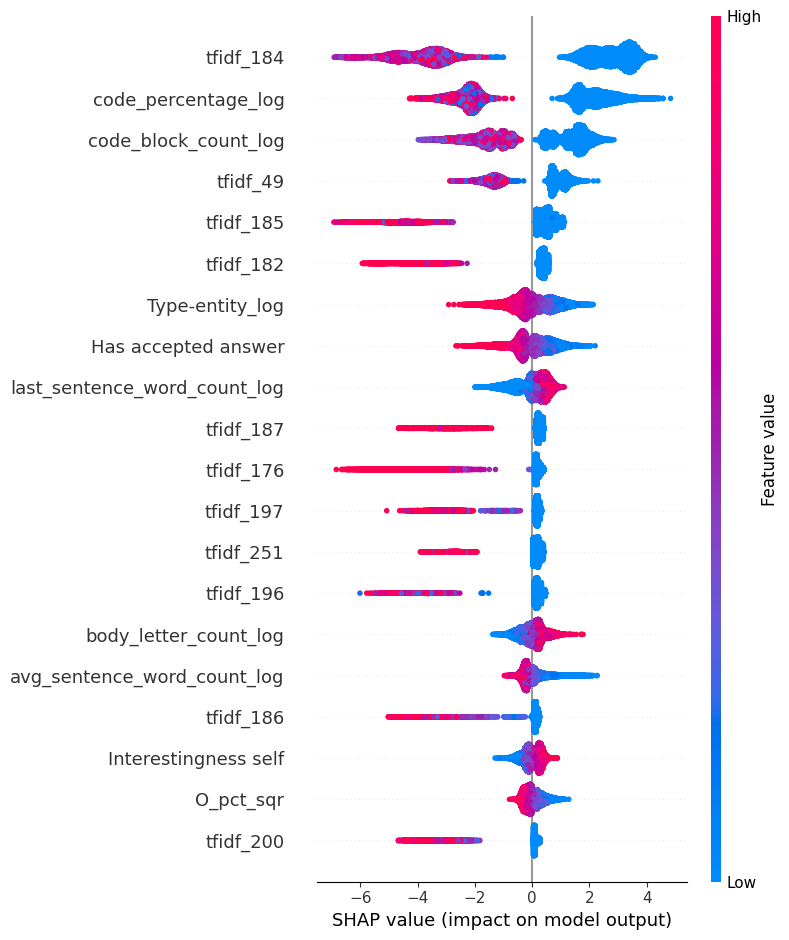


SHAP summary for task: task_close


<ipython-input-13-53cdb2002fa9>:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


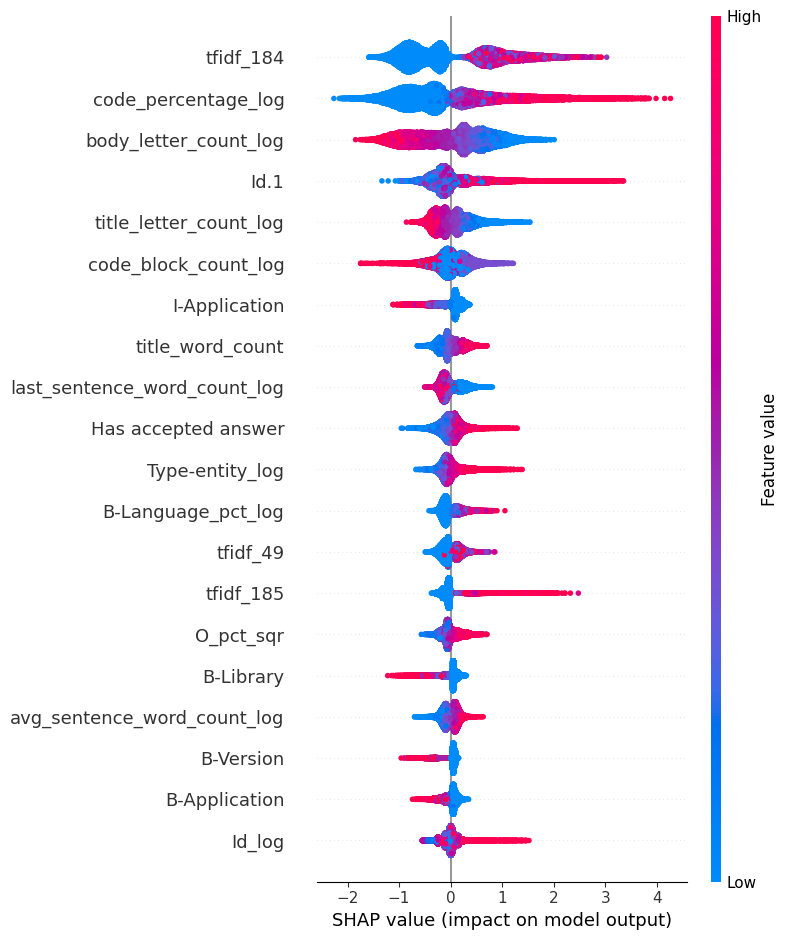

In [ ]:
for task_name in tasks:
    print(f"\nSHAP summary for task: {task_name}")
    shap.summary_plot(
        shap_values_all[task_name],
        X_val_all[task_name],
        feature_names=X.columns.tolist()
    )

In [ ]:
print(X.columns)

Index(['O', 'B-Language', 'B-Library', 'I-Library', 'I-Function', 'B-Value',
       'I-Value', 'B-Application', 'B-User_Name', 'B-Data_Type',
       ...
       'tfidf_288', 'tfidf_290', 'tfidf_291', 'tfidf_293', 'tfidf_294',
       'tfidf_295', 'tfidf_296', 'tfidf_297', 'tfidf_298', 'tfidf_299'],
      dtype='object', length=837)


In [ ]:
print(X.head())

          O  B-Language  B-Library  I-Library  I-Function   B-Value   I-Value  \
0  0.437500        0.05   0.235294      0.125       0.075  0.037736  0.011494   
1  0.171875        0.10   0.000000      0.000       0.000  0.000000  0.000000   
2  0.671875        0.00   0.117647      0.000       0.000  0.000000  0.000000   
3  0.734375        0.00   0.058824      0.000       0.000  0.037736  0.022989   
4  0.570312        0.00   0.000000      0.025       0.000  0.132075  0.000000   

   B-Application  B-User_Name  B-Data_Type  ...  tfidf_288  tfidf_290  \
0       0.034483     0.083333     0.000000  ...   0.000000   0.101336   
1       0.000000     0.000000     0.076923  ...   0.527089   0.000000   
2       0.000000     0.000000     0.000000  ...   0.000000   0.104037   
3       0.000000     0.000000     0.038462  ...   0.142351   0.081926   
4       0.000000     0.000000     0.000000  ...   0.000000   0.149558   

   tfidf_291  tfidf_293  tfidf_294  tfidf_295  tfidf_296  tfidf_297  \
0  

In [ ]:
!pip install yake

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 16.6 MB/s eta 0:00:00


In [ ]:
import yake
from tqdm import tqdm

kw_extractor = yake.KeywordExtractor(
    lan="en",        # language
    n=2,             # max n‑gram size => up to 2 words
    top=1,           # return only the single highest‑scoring phrase
    dedupLim=0.9,    # deduplication threshold
    windowsSize=1    # context window for co‑occurrence
)

def extract_two_word(text):
    kws = kw_extractor.extract_keywords(text)
    return kws[0][0] if kws else ""

tqdm.pandas(desc="YAKE Extraction")
df['YAKE_TwoWord'] = df['processed_text'].progress_apply(extract_two_word)


YAKE Extraction:   2%|▏         | 733/45000 [00:08<07:48, 94.44it/s]Exception ignored in: <function DataIter.__del__ at 0x7b898bd825c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 572, in __del__
    assert self._temporary_data is None
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: 
YAKE Extraction: 100%|██████████| 45000/45000 [05:10<00:00, 144.83it/s]


In [ ]:
print(df[['Title','YAKE_TwoWord']].head(10))

                                               Title     YAKE_TwoWord
0             Java: Repeat Task Every Random Seconds      java repeat
1                  Why are Java Optionals immutable?    immutable pid
2  Text Overlay Image with Darkened Opacity React...    neue fontsize
3         Why ternary operator in swift is so picky?       picky pthe
4                 hide/show fab with scale animation     hideshow fab
5  Accessing pointer member of the structure usin...         type int
6  How To Disable 2nd Saturday 4th Saturday ,Sund...  saturday sunday
7                   Resizing containers in bootstrap          div div
8  Changing Theme in Windows 10 UWP App Programma...          uwp app
9                       TextBox Value Disappears VB6      click event


In [ ]:
!pip install keybert sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.9 MB/s eta 0:00:00


In [ ]:
from keybert import KeyBERT

kw_model = KeyBERT(model='all-MiniLM-L6-v2')

tqdm.pandas(desc="KeyBERT per‑row")

def extract_two_word_keybert(text):
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 3),
        stop_words='english',
        top_n=2
    )
    return ' '.join([phrase for phrase, score in keywords]) if keywords else ''

batch_size = 200
summaries = []
texts = df['processed_text'].tolist()

df['KeyBERT_TwoWord'] = df['processed_text'].progress_apply(extract_two_word_keybert)


KeyBERT per‑row: 100%|██████████| 45000/45000 [45:47<00:00, 16.38it/s]


In [ ]:
print(df[['Title', 'KeyBERT_TwoWord']].head(10))

                                               Title  \
0             Java: Repeat Task Every Random Seconds   
1                  Why are Java Optionals immutable?   
2  Text Overlay Image with Darkened Opacity React...   
3         Why ternary operator in swift is so picky?   
4                 hide/show fab with scale animation   
5  Accessing pointer member of the structure usin...   
6  How To Disable 2nd Saturday 4th Saturday ,Sund...   
7                   Resizing containers in bootstrap   
8  Changing Theme in Windows 10 UWP App Programma...   
9                       TextBox Value Disappears VB6   

                                     KeyBERT_TwoWord  
0                       java repeat task java repeat  
1   java optionals immutable optionals immutable pid  
2   opacity 06 articlepreview image darkened opacity  
3      ternary operator swift optionals use codecode  
4  floatingactionmenu need implement custom float...  
5    using structure pointer pointer using structure 

In [ ]:
!pip install transformers

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [ ]:
checkpoint = "google/flan-t5-small"
tokenizer = T5Tokenizer.from_pretrained(checkpoint)
model     = T5ForConditionalGeneration.from_pretrained(checkpoint)

model.eval()
if torch.cuda.is_available():
    model.cuda()

# 5) Helper to post‑process generated text
def two_word_from_output(output_ids):
    text = tokenizer.decode(output_ids, skip_special_tokens=True)
    words = text.strip().split()
    return " ".join(words[:2])

# 6) Batch‑inference loop
batch_size = 16
summaries = []

for i in tqdm(range(0, len(df), batch_size), desc="T5 batches"):
    batch_texts = [
        "summarize using two technical terms: " + txt
        for txt in df['processed_text'].iloc[i : i + batch_size]
    ]
    # 6a) Tokenize with padding
    inputs = tokenizer(
        batch_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )
    if torch.cuda.is_available():
        inputs = {k:v.cuda() for k,v in inputs.items()}

    # 6b) Generate (one forward pass)
    outputs = model.generate(
        **inputs,
        max_new_tokens=8,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2
    )

    # 6c) Decode each output to 2 words
    for out_ids in outputs:
        summaries.append(two_word_from_output(out_ids))

# 7) Attach back to your DataFrame
df['T5_TwoWordTech'] = summaries

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5 batches: 100%|██████████| 2813/2813 [23:02<00:00,  2.03it/s]


In [ ]:
print(df[['Title', 'T5_TwoWordTech']].head(10))

                                               Title       T5_TwoWordTech
0             Java: Repeat Task Every Random Seconds          java repeat
1                  Why are Java Optionals immutable?               java 8
2  Text Overlay Image with Darkened Opacity React...          resize mode
3         Why ternary operator in swift is so picky?  sstartindex codepre
4                 hide/show fab with scale animation    summary: hideshow
5  Accessing pointer member of the structure usin...              phow to
6  How To Disable 2nd Saturday 4th Saturday ,Sund...               i want
7                   Resizing containers in bootstrap                 i am
8  Changing Theme in Windows 10 UWP App Programma...       Changing theme
9                       TextBox Value Disappears VB6        textbox value


In [ ]:

df.to_csv("train_final_explain.csv", index=False)

In [ ]:
df.head()

,Id,Title,Body,Tags,CreationDate,Y,processed_text,O,B-Language,B-Library,...,I-Data_Structure_pct,I-Website_count,I-Website_pct,B-Keyboard_IP_count,B-Keyboard_IP_pct,I-Keyboard_IP_count,I-Keyboard_IP_pct,YAKE_TwoWord,KeyBERT_TwoWord,T5_TwoWordTech
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,1,java repeat task every random seconds pim alre...,56.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,java repeat,java repeat task java repeat,java repeat
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,0,why are java optionals immutable pid like to u...,22.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,immutable pid,java optionals immutable optionals immutable pid,java 8
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,0,text overlay image with darkened opacity react...,86.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neue fontsize,opacity 06 articlepreview image darkened opacity,resize mode
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,0,why ternary operator in swift is so picky pthe...,94.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,picky pthe,ternary operator swift optionals use codecode,sstartindex codepre
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,0,hideshow fab with scale animation pim using cu...,73.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hideshow fab,floatingactionmenu need implement custom float...,summary: hideshow


In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/train_final_explain.csv")
df1.head()

,Id,Title,Body,Tags,CreationDate,Y,processed_text,O,B-Language,B-Library,...,I-Data_Structure_pct,I-Website_count,I-Website_pct,B-Keyboard_IP_count,B-Keyboard_IP_pct,I-Keyboard_IP_count,I-Keyboard_IP_pct,YAKE_TwoWord,KeyBERT_TwoWord,T5_TwoWordTech
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,1,java repeat task every random seconds pim alre...,56.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,java repeat,java repeat task java repeat,java repeat
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,0,why are java optionals immutable pid like to u...,22.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,immutable pid,java optionals immutable optionals immutable pid,java 8
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,0,text overlay image with darkened opacity react...,86.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neue fontsize,opacity 06 articlepreview image darkened opacity,resize mode
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,0,why ternary operator in swift is so picky pthe...,94.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,picky pthe,ternary operator swift optionals use codecode,sstartindex codepre
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,0,hideshow fab with scale animation pim using cu...,73.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hideshow fab,floatingactionmenu need implement custom float...,summary: hideshow


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from tqdm.auto import tqdm

# 1) Load T5 + tokenizer
checkpoint = "google/flan-t5-small"
tokenizer  = T5Tokenizer.from_pretrained(checkpoint)
model      = T5ForConditionalGeneration.from_pretrained(checkpoint)
model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 2) Prepare a placeholder for rephrased text
df["rephrased_text"] = df["processed_text"]

# 3) Gather indices needing rephrase (Y == 2)
lq_edit_idx = df.index[df["Y"] == 2].tolist()

# 4) Batch-inference parameters
batch_size = 32
prompt_prefix = "Improve this question so it reads like a high-quality Stack Overflow post:\n\n"

# 5) Loop in batches, paraphrase, and assign
for start in tqdm(range(0, len(lq_edit_idx), batch_size), desc="Rephrasing LQ_EDIT"):
    batch_idx   = lq_edit_idx[start : start + batch_size]
    batch_texts = [ prompt_prefix + t for t in df.loc[batch_idx, "processed_text"] ]

    # tokenize the batch
    inputs = tokenizer(
        batch_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(device)

    # generate rephrasings
    outputs = model.generate(
        **inputs,
        max_new_tokens=128,
        num_beams=5,
        early_stopping=True,
        no_repeat_ngram_size=2
    )

    # decode and store
    rephrasings = [ tokenizer.decode(o, skip_special_tokens=True) for o in outputs ]
    df.loc[batch_idx, "rephrased_text"] = rephrasings



Rephrasing LQ_EDIT:   0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
df[ df["Y"]==2 ][ ["processed_text","rephrased_text"] ].head(10)

,processed_text,rephrased_text
6,how to disable 2nd saturday 4th saturday sunda...,i want to disable 2nd Saturday 4th Saturday su...
7,resizing containers in bootstrap i am new to b...,1 http://tackimgur.coms16wbpng
9,textbox value disappears vb6 i my case i am ha...,What is happening in my form 2 textbox?
12,iosobjectivecxcode expand label based on quant...,iosobjectivecxcode expand label based on quant...
13,output file is this a fault my code here inclu...,http://tackimgur.comgapqypng
18,how to create a function that returns a byte a...,httppastebincom8ud9ny2u
22,stopwatch and readkey doesnt work properly im ...,Stack Overflow post: stopwatch and readkey doe...
23,vbscript email attachment im writing a vbscrip...,Stack Overflow post: vbscript email attachment...
28,i need to create an array with numbers given b...,Stack Overflow post: i need to create an array...
30,c vector type function implemetation class cit...,what wrong with my program? I don't understand...


In [ ]:

!pip install transformers datasets evaluate bert-score sacrebleu --quiet

from datasets import Dataset
import evaluate
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)

ft_df = (
    df[df["Y"].isin([0, 2])]
    .loc[:, ["Y", "processed_text", "rephrased_text"]]
    .rename(columns={
        "processed_text": "input_text",
        "rephrased_text": "target_text"
    })
    .reset_index(drop=True)
)

ft_df.loc[ft_df["Y"] == 0, "target_text"] = ft_df.loc[ft_df["Y"] == 0, "input_text"]

hf_ds = Dataset.from_pandas(ft_df)

checkpoint = "google/flan-t5-small"
tokenizer  = T5Tokenizer.from_pretrained(checkpoint)
model      = T5ForConditionalGeneration.from_pretrained(checkpoint)
device     = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def preprocess(batch):
    inputs = tokenizer(
        ["Improve this question so it reads like a high-quality Stack Overflow post:\n\n" + txt for txt in batch["input_text"]],
        truncation=True,
        padding="longest",
        max_length=512
    )
    targets = tokenizer(
        batch["target_text"],
        truncation=True,
        padding="longest",
        max_length=128
    )
    return {
        "input_ids":     inputs.input_ids,
        "attention_mask":inputs.attention_mask,
        "labels":        targets.input_ids
    }

tokenized_ds = hf_ds.map(
    preprocess,
    batched=True,
    remove_columns=hf_ds.column_names
)

bertscore = evaluate.load("bertscore")
bleu      = evaluate.load("bleu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    bert_res = bertscore.compute(predictions=decoded_preds,
                                 references=decoded_labels,
                                 lang="en")
    bleu_res = bleu.compute(predictions=decoded_preds,
                            references=[[ref] for ref in decoded_labels])
    return {
        "bertscore_precision": np.mean(bert_res["precision"]),
        "bertscore_recall":    np.mean(bert_res["recall"]),
        "bertscore_f1":        np.mean(bert_res["f1"]),
        "bleu":                bleu_res["score"]
    }

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=-100
)

training_args = Seq2SeqTrainingArguments(
    output_dir="flan_t5_rephraser",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_steps=100,
    save_steps=500,
    do_eval=True,
    eval_steps=500,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds,
    eval_dataset=tokenized_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

train_loader = trainer.get_train_dataloader()
batch = next(iter(train_loader))
batch = {k: v.to(device) for k, v in batch.items()}

print("Batch keys:", batch.keys())
print("input_ids shape:", batch["input_ids"].shape)
print("labels shape:   ", batch["labels"].shape)
print("Sample labels (first example):", batch["labels"][0][:20])
print("Unique label values:", torch.unique(batch["labels"][0]))

out = model(**batch)
print("Raw model loss:", out.loss)
trainer.train()

trainer.save_model("flan_t5_rephraser")
tokenizer.save_pretrained("flan_t5_rephraser")


Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

<ipython-input-23-8ab3dcd4d488>:113: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Batch keys: dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])
input_ids shape: torch.Size([8, 512])
labels shape:    torch.Size([8, 128])
Sample labels (first example): tensor([ 1389,    23,   172,    52,   149,    12,  3806,     3,     7,  8076,
           23,    26,  1341,    12,  4208, 10409,     3,   102,  4067,    54],
       device='cuda:0')
Unique label values: tensor([    1,     3,     7,     8,     9,    12,    15,    16,    21,    23,
           26,    29,    49,    51,    52,    54,    60,    82,    89,   102,
          107,   127,   149,   158,   166,   172,   194,   226,   228,   287,
          338,   536,   554,   564,   580,   632,   826,  1010,  1023,  1081,
         1139,  1341,  1383,  1389,  1773,  1986,  2026,  2128,  2816,  3806,
         4067,  4208,  4350,  4885,  4893,  4978,  5846,  5948,  6634,  7699,
         8076,  8221,  8318,  9208, 10409, 12110, 12317, 12651, 14574, 16137,
        16281, 16420, 22999, 25866, 26622, 27341], device='

Step,Training Loss
100,0.000000
200,0.000000
300,0.000000
400,0.000000
500,0.000000
600,0.000000
700,0.000000
800,0.000000
900,0.000000
1000,0.000000


('flan_t5_rephraser/tokenizer_config.json',
 'flan_t5_rephraser/special_tokens_map.json',
 'flan_t5_rephraser/spiece.model',
 'flan_t5_rephraser/added_tokens.json')

In [ ]:
df.to_csv("train_rephrase.csv", index=False)

In [ ]:
!zip -r /content/flan_t5_rephraser.zip /content/flan_t5_rephraser

from google.colab import files
files.download('/content/flan_t5_rephraser.zip')

  adding: content/flan_t5_rephraser/ (stored 0%)
  adding: content/flan_t5_rephraser/spiece.model (deflated 48%)
  adding: content/flan_t5_rephraser/checkpoint-1500/ (stored 0%)
  adding: content/flan_t5_rephraser/checkpoint-1500/spiece.model (deflated 48%)
  adding: content/flan_t5_rephraser/checkpoint-1500/special_tokens_map.json (deflated 85%)
  adding: content/flan_t5_rephraser/checkpoint-1500/trainer_state.json (deflated 81%)
  adding: content/flan_t5_rephraser/checkpoint-1500/tokenizer_config.json (deflated 94%)
  adding: content/flan_t5_rephraser/checkpoint-1500/training_args.bin (deflated 51%)
  adding: content/flan_t5_rephraser/checkpoint-1500/config.json (deflated 62%)
  adding: content/flan_t5_rephraser/checkpoint-1500/added_tokens.json (deflated 83%)
  adding: content/flan_t5_rephraser/checkpoint-1500/scheduler.pt (deflated 57%)
  adding: content/flan_t5_rephraser/checkpoint-1500/scaler.pt (deflated 60%)
  adding: content/flan_t5_rephraser/checkpoint-1500/model.safetensors 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
import json

drive.mount('/content/drive')

!unzip -o "/content/drive/MyDrive/flan_t5_rephraser.zip" -d /content/flan_t5_rephraser

import os
state_path = "/content/flan_t5_rephraser/trainer_state.json"
if os.path.exists(state_path):
    with open(state_path) as f:
        ts = json.load(f)
    print(json.dumps(ts, indent=2))
else:
    print("No trainer_state.json found—logs weren’t saved here.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/flan_t5_rephraser.zip
   creating: /content/flan_t5_rephraser/content/flan_t5_rephraser/
  inflating: /content/flan_t5_rephraser/content/flan_t5_rephraser/spiece.model  
   creating: /content/flan_t5_rephraser/content/flan_t5_rephraser/checkpoint-1500/
  inflating: /content/flan_t5_rephraser/content/flan_t5_rephraser/checkpoint-1500/spiece.model  
  inflating: /content/flan_t5_rephraser/content/flan_t5_rephraser/checkpoint-1500/special_tokens_map.json  
  inflating: /content/flan_t5_rephraser/content/flan_t5_rephraser/checkpoint-1500/trainer_state.json  
  inflating: /content/flan_t5_rephraser/content/flan_t5_rephraser/checkpoint-1500/tokenizer_config.json  
  inflating: /content/flan_t5_rephraser/content/flan_t5_rephraser/checkpoint-1500/training_args.bin  
  inflating: /content/flan_t5_rephraser/content/flan_t5_rephraser/che

In [ ]:
import pandas as pd
import numpy as np
import torch
import joblib
import re
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForTokenClassification
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

model_dir = "/content/drive/MyDrive/Ner"
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_dir)
ner_model = AutoModelForTokenClassification.from_pretrained(model_dir).to(device)
ner_model.eval()

class DropLowCorrFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01):
        self.threshold = threshold

    def fit(self, X, y=None):
        # Ensure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        # 1) Select only numeric columns for correlation
        numeric = X.select_dtypes(include=[np.number])

        # 2) Compute correlations with y over those numeric columns
        corr = numeric.corrwith(pd.Series(y, index=numeric.index)).abs()

        # 3) Record features to drop
        self.to_drop_ = corr[corr < self.threshold].index.tolist()
        return self

    def transform(self, X):
        # Ensure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        return X.drop(columns=self.to_drop_, errors="ignore")

def basic_preprocessing(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def _add_processed_text(df):
    df = df.copy()
    df["processed_text"] = (
        df["Title"].fillna("") + " " + df["Body"].fillna("")
    ).apply(basic_preprocessing)
    return df

add_processed = FunctionTransformer(func=_add_processed_text, validate=False)

class SubjectiveTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, batch_size=32):
        self.batch_size = batch_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is list‐like of raw texts
        return simulate_subjective_indicators(list(X), batch_size=self.batch_size)

    def get_feature_names_out(self, input_features=None):
        # 20 dims → subj_0 … subj_19
        return [f"subj_{i}" for i in range(20)]

subjective_step = SubjectiveTransformer(batch_size=32)

def _ner_dicts(texts):
    out = []
    for txt in tqdm(texts, desc="NER inference"):
        pairs = ner_inference(
            [txt], tokenizer, ner_model, device, batch_size=16
        )[0]
        out.append(ner_features(pairs))
    return out

ner_step = FunctionTransformer(func=_ner_dicts, validate=False)

def _softner(dicts):
    feats = []
    for d in dicts:
        total = sum(d.values())
        row = {"total_ner_tokens": total}
        for lab, cnt in d.items():
            row[f"{lab}_count"] = cnt
            row[f"{lab}_pct"]   = cnt/total if total>0 else 0.0
        feats.append(row)
    return feats

softner_step = FunctionTransformer(func=_softner, validate=False)


class NERSoftTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, inner_pipeline):
        self.inner_pipeline = inner_pipeline

    def fit(self, X, y=None):
        self.inner_pipeline.fit(X, y)
        return self

    def transform(self, X):
        return self.inner_pipeline.transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.inner_pipeline.named_steps["vec"].get_feature_names_out()

def _lexical(X):
    if isinstance(X, pd.DataFrame):
        titles = X.iloc[:, 0]
        bodies = X.iloc[:, 1]
    else:
        titles = [row[0] for row in X]
        bodies = [row[1] for row in X]

    feats = []
    for t, b in tqdm(zip(titles, bodies),
                    total=len(titles),
                    desc="Lexical features"):
        feats.append(extract_lexical_features(t, b))
    return feats

lexical_step = FunctionTransformer(func=_lexical, validate=False)

class LexicalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, inner_pipeline):
        self.inner_pipeline = inner_pipeline

    def fit(self, X, y=None):
        self.inner_pipeline.fit(X, y)
        return self

    def transform(self, X):
        return self.inner_pipeline.transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.inner_pipeline.named_steps["vec"].get_feature_names_out()

def _drop_duplicate_df(X):
    cols = feature_union.get_feature_names_out()
    df   = pd.DataFrame(X, columns=cols)
    # keep only the first occurrence of each column
    df   = df.loc[:, ~df.columns.duplicated()]
    return df

drop_dupes = FunctionTransformer(func=_drop_duplicate_df, validate=False)

def _numeric_gen(df: pd.DataFrame):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns.difference(["Y"])
    gen = pd.DataFrame(index=df.index)
    for col in numeric_cols:
        data = df[col]
        gen[f"{col}_log"]  = np.log1p(np.maximum(data, 0))
        gen[f"{col}_sqr"]  = np.power(data, 2)
        gen[f"{col}_sqrt"] = np.sqrt(np.maximum(data, 0))
    return pd.concat([df, gen], axis=1)

numeric_step = FunctionTransformer(func=_numeric_gen, validate=False)

scaler = MinMaxScaler()
def _scale_df(df: pd.DataFrame):
    df = df.copy()
    feature_cols = df.select_dtypes(include=[np.number]).columns.difference(["Y"])
    df[feature_cols] = scaler.fit_transform(df[feature_cols])
    return df

scale_step = FunctionTransformer(func=_scale_df, validate=False)

def _add_tfidf_features(df: pd.DataFrame):
    df = df.copy()
    tfidf = TfidfVectorizer(max_features=300)
    mat   = tfidf.fit_transform(df["processed_text"].fillna(""))
    toks  = tfidf.get_feature_names_out()
    tfidf_df = pd.DataFrame(
        mat.toarray(),
        index=df.index,
        columns=[f"tfidf_{tok}" for tok in toks]
    )
    return pd.concat([df, tfidf_df], axis=1)

tfidf_step = FunctionTransformer(func=_add_tfidf_features, validate=False)

def _array_to_df(X):
    cols = feature_union.get_feature_names_out()
    return pd.DataFrame(X, columns=cols)

array_to_df = FunctionTransformer(func=_array_to_df, validate=False)


raw_ner_soft = Pipeline([
    ("ner_dicts", ner_step),
    ("softner",    softner_step),
    ("vec",        DictVectorizer(sparse=False)),
])


ner_soft_pipeline = NERSoftTransformer(raw_ner_soft)

raw_lexical = Pipeline([
    ("lex_dicts", lexical_step),
    ("vec",       DictVectorizer(sparse=False)),
])

lexical_pipeline = LexicalTransformer(raw_lexical)

feature_union = ColumnTransformer(
    [
        ("subj",     subjective_step,           "processed_text"),
        ("ner_soft", ner_soft_pipeline,         "processed_text"),
        ("lexical",  lexical_pipeline,  ["Title", "Body"]),
        ("keep_text", "passthrough",     ["processed_text"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)


feature_pipeline = Pipeline([
    ("add_text",     add_processed),
    ("extract_feats", feature_union),
    ("to_df",         array_to_df),
    ("dedupe",       drop_dupes),
    ("numeric_gen",  numeric_step),
    ("add_tfidf",    tfidf_step),
    ("scale",        scale_step),
    ("drop_low_corr", DropLowCorrFeatures(threshold=0.01)),
])

train_df = pd.read_csv("/content/drive/MyDrive/train.csv")

y_train = train_df["Y"]
le = LabelEncoder()
y_train = le.fit_transform(train_df["Y"].astype(str))

feature_pipeline.fit(train_df, y_train)

joblib.dump(
    feature_pipeline,
    "/content/drive/MyDrive/feature_pipeline.pkl"
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

NER inference:   0%|          | 0/45000 [00:00<?, ?it/s]

NER inference:   0%|          | 0/45000 [00:00<?, ?it/s]

Lexical features:   0%|          | 0/45000 [00:00<?, ?it/s]

Lexical features:   0%|          | 0/45000 [00:00<?, ?it/s]

['/content/drive/MyDrive/feature_pipeline.pkl']

In [ ]:
import pandas as pd
import numpy as np
import torch
import joblib
import re
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForTokenClassification
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

model_dir = "/content/drive/MyDrive/Ner"
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_dir)
ner_model = AutoModelForTokenClassification.from_pretrained(model_dir).to(device)
ner_model.eval()

class DropLowCorrFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01):
        self.threshold = threshold

    def fit(self, X, y=None):
        # Ensure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        # 1) Select only numeric columns for correlation
        numeric = X.select_dtypes(include=[np.number])

        # 2) Compute correlations with y over those numeric columns
        corr = numeric.corrwith(pd.Series(y, index=numeric.index)).abs()

        # 3) Record features to drop
        self.to_drop_ = corr[corr < self.threshold].index.tolist()
        return self

    def transform(self, X):
        # Ensure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        return X.drop(columns=self.to_drop_, errors="ignore")

def basic_preprocessing(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def _add_processed_text(df):
    df = df.copy()
    df["processed_text"] = (
        df["Title"].fillna("") + " " + df["Body"].fillna("")
    ).apply(basic_preprocessing)
    return df

add_processed = FunctionTransformer(func=_add_processed_text, validate=False)

class SubjectiveTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, batch_size=32):
        self.batch_size = batch_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is list‐like of raw texts
        return simulate_subjective_indicators(list(X), batch_size=self.batch_size)

    def get_feature_names_out(self, input_features=None):
        # 20 dims → subj_0 … subj_19
        return [f"subj_{i}" for i in range(20)]

subjective_step = SubjectiveTransformer(batch_size=32)

def _ner_dicts(texts):
    out = []
    for txt in tqdm(texts, desc="NER inference"):
        pairs = ner_inference(
            [txt], tokenizer, ner_model, device, batch_size=16
        )[0]
        out.append(ner_features(pairs))
    return out

ner_step = FunctionTransformer(func=_ner_dicts, validate=False)

def _softner(dicts):
    feats = []
    for d in dicts:
        total = sum(d.values())
        row = {"total_ner_tokens": total}
        for lab, cnt in d.items():
            row[f"{lab}_count"] = cnt
            row[f"{lab}_pct"]   = cnt/total if total>0 else 0.0
        feats.append(row)
    return feats

softner_step = FunctionTransformer(func=_softner, validate=False)


class NERSoftTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, inner_pipeline):
        self.inner_pipeline = inner_pipeline

    def fit(self, X, y=None):
        self.inner_pipeline.fit(X, y)
        return self

    def transform(self, X):
        return self.inner_pipeline.transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.inner_pipeline.named_steps["vec"].get_feature_names_out()

def _lexical(X):
    if isinstance(X, pd.DataFrame):
        titles = X.iloc[:, 0]
        bodies = X.iloc[:, 1]
    else:
        titles = [row[0] for row in X]
        bodies = [row[1] for row in X]

    feats = []
    for t, b in tqdm(zip(titles, bodies),
                    total=len(titles),
                    desc="Lexical features"):
        feats.append(extract_lexical_features(t, b))
    return feats

lexical_step = FunctionTransformer(func=_lexical, validate=False)

class LexicalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, inner_pipeline):
        self.inner_pipeline = inner_pipeline

    def fit(self, X, y=None):
        self.inner_pipeline.fit(X, y)
        return self

    def transform(self, X):
        return self.inner_pipeline.transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.inner_pipeline.named_steps["vec"].get_feature_names_out()

def _drop_duplicate_df(X):
    cols = feature_union.get_feature_names_out()
    df   = pd.DataFrame(X, columns=cols)
    # keep only the first occurrence of each column
    df   = df.loc[:, ~df.columns.duplicated()]
    return df

drop_dupes = FunctionTransformer(func=_drop_duplicate_df, validate=False)

def _numeric_gen(df: pd.DataFrame):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns.difference(["Y"])
    gen = pd.DataFrame(index=df.index)
    for col in numeric_cols:
        data = df[col]
        gen[f"{col}_log"]  = np.log1p(np.maximum(data, 0))
        gen[f"{col}_sqr"]  = np.power(data, 2)
        gen[f"{col}_sqrt"] = np.sqrt(np.maximum(data, 0))
    return pd.concat([df, gen], axis=1)

numeric_step = FunctionTransformer(func=_numeric_gen, validate=False)

scaler = MinMaxScaler()
def _scale_df(df: pd.DataFrame):
    df = df.copy()
    feature_cols = df.select_dtypes(include=[np.number]).columns.difference(["Y"])
    df[feature_cols] = scaler.fit_transform(df[feature_cols])
    return df

scale_step = FunctionTransformer(func=_scale_df, validate=False)

def _add_tfidf_features(df: pd.DataFrame):
    df = df.copy()
    tfidf = TfidfVectorizer(max_features=300)
    mat   = tfidf.fit_transform(df["processed_text"].fillna(""))
    toks  = tfidf.get_feature_names_out()
    tfidf_df = pd.DataFrame(
        mat.toarray(),
        index=df.index,
        columns=[f"tfidf_{tok}" for tok in toks]
    )
    return pd.concat([df, tfidf_df], axis=1)

tfidf_step = FunctionTransformer(func=_add_tfidf_features, validate=False)

def _array_to_df(X):
    cols = feature_union.get_feature_names_out()
    return pd.DataFrame(X, columns=cols)

array_to_df = FunctionTransformer(func=_array_to_df, validate=False)


raw_ner_soft = Pipeline([
    ("ner_dicts", ner_step),
    ("softner",    softner_step),
    ("vec",        DictVectorizer(sparse=False)),
])


ner_soft_pipeline = NERSoftTransformer(raw_ner_soft)

raw_lexical = Pipeline([
    ("lex_dicts", lexical_step),
    ("vec",       DictVectorizer(sparse=False)),
])

lexical_pipeline = LexicalTransformer(raw_lexical)

feature_union = ColumnTransformer(
    [
        ("subj",     subjective_step,           "processed_text"),
        ("ner_soft", ner_soft_pipeline,         "processed_text"),
        ("lexical",  lexical_pipeline,  ["Title", "Body"]),
        ("keep_text", "passthrough",     ["processed_text"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)


feature_pipeline = Pipeline([
    ("add_text",     add_processed),
    ("extract_feats", feature_union),
    ("to_df",         array_to_df),
    ("dedupe",       drop_dupes),
    ("numeric_gen",  numeric_step),
    ("add_tfidf",    tfidf_step),
    ("scale",        scale_step),
    ("drop_low_corr", DropLowCorrFeatures(threshold=0.01)),
])

In [ ]:
feature_pipeline = joblib.load("/content/drive/MyDrive/feature_pipeline.pkl")

models = {
    "close":        joblib.load("/content/drive/MyDrive/best_model_task_close.pkl"),
    "edit":         joblib.load("/content/drive/MyDrive/best_model_task_edit.pkl"),
    "high_quality": joblib.load("/content/drive/MyDrive/best_model_task_high_quality.pkl")
}

def predict_title_body(title: str, body: str):
    """
    Given a Title and Body string, returns:
      - binary predictions for each model
      - positive‐class probabilities for each model
      - a “winner‐takes‐all” label (model with highest proba)
    """

    df = pd.DataFrame({
        "Title":        [title],
        "Body":         [body],
        "Tags":         ["dummy_tag"],               # dummy tag string
        "CreationDate": [pd.Timestamp.now()],        # current timestamp
        "Id":           [0],                         # dummy Id
        "Y":            [0]                          # dummy target, not used during inference
    })

    expected_features = models["close"].get_booster().feature_names

    # Extract features using the feature pipeline
    X = feature_pipeline.transform(df)
    X = pd.DataFrame(X)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

    if X.shape[1] == len(expected_features):
        X.columns = expected_features
    else:
        # If not, skip assigning and just fix mismatches manually
        current_cols = list(X.columns)
        X = pd.DataFrame(X, columns=current_cols)

    for col in expected_features:
        if col not in X.columns:
            X[col] = 0

    X = X[expected_features]
    print((X != 0).sum(axis=1))
    # Predict using each binary classifier
    preds = {}
    probas = {}
    for name, model in models.items():
        preds[name] = int(model.predict(X)[0])
        probas[name] = float(model.predict_proba(X)[0, 1])

    winner = max(probas, key=probas.get)

    return preds, probas, winner

# ─── Example usage ───────────────────────────────────────────────────────────
title = "How to implement a feature engineering pipeline using Scikit-learn?"
body = "I am working on a machine learning project and want to design a clean and modular feature engineering pipeline using Scikit-learn. I plan to include steps like text preprocessing, TF-IDF, NER-based features, and maybe even sentiment scores. Could someone provide a working example or point out best practices for combining multiple preprocessing steps (including custom transformers) in a pipeline? Code snippets and suggestions for handling train-test leakage would also be appreciated."

preds, probas, winner = predict_title_body(title, body)
print("Binary predictions:", preds)
print("Positive‐class probabilities:", probas)
print("Predicted class (highest proba):", winner)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

NER inference:   0%|          | 0/1 [00:00<?, ?it/s]

Lexical features:   0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-27-1792a3bed034>:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col] = 0
<ipython-input-27-1792a3bed034>:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col] = 0
<ipython-input-27-1792a3bed034>:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col] = 0
<ipython-input-27-1792

0    21
dtype: int64
Binary predictions: {'close': 0, 'edit': 1, 'high_quality': 0}
Positive‐class probabilities: {'close': 0.11832209676504135, 'edit': 0.998156726360321, 'high_quality': 7.844289939384907e-05}
Predicted class (highest proba): edit
